# Imports

In [14]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets, linear_model
from sklearn import tree
import sklearn.cluster as cluster
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
import plotly.express as px
import plotly.graph_objects as go
from scipy.optimize import minimize

np.random.seed(1234)

In [ ]:
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
plt.rcParams.update({"axes.grid": True, "figure.figsize": (8, 4)})
import seaborn as sns

# sns.set()

# Overview - NN for Vision Systems

A convolutional neural network (CNN) is an algorithm that processes deep learning input images by assigning importance to weights and biases for various aspects and objects in the images. Then, it works to distinguish the input images from one another. A CNN is built similarly to the connectivity pattern of neurons in the human brain and is based on the organization of the visual cortex. An individual neuron responds to stimuli only in a limited visual field region, known as the receptive field. The receptive field overlaps with the visual field, covering it entirely. 

CNNs perform better with image, speech, or audio inputs than other neural networks. There are three main layers in CNNs:
- Convolutional layer
- Pooling layer
- Fully connected (FC) layer

# 23.1 Convolutional NN

Before CNN, consider a basic non convolutional approach to NN and image classification
- Vectorize the image by concatenating every row together
- Then pass to 1 or more dense layers
- Finish with a softmax to get a probability per class

While this work pretty well for simpler images, it doesn't make a lot of intuitive sense
- why destroy the visual arrangement in a 2d image by vectorizing it as shown below

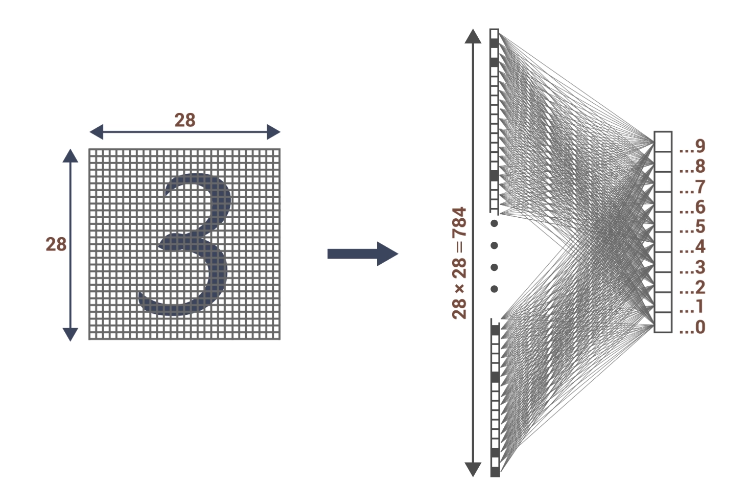

Some properties of natural images that make a vectorization of them ill-advised, they are
- Spatially correlated
    - If a block of pixels is white, its likely that an interior pixel in that block is also white
- Composed of a heirarchical structure
    - Images tend to be built of smaller building blocks that can be reused (i.e. reappear) elsewhere in the image
- Translationally invariant
    - An image of a cat is still a cat, even if you slide it up or down, left or right

So what is desirable is a type of NN that preserves / recognizes / makes use of these properties
- A CNN does this

Reviewing convolution
- Given an MxN image chip
- Pointwise multiply with a kernel matched to the size of the image chip
- Sum the result
- Add a bias
- And invoke an activation function
- Together this maps the chip to a scalar value, which is the output of the filter for the center pixel of the chip

To form the full output, apply the filter in a sliding fashion across the entire image
- The filtered image can be called a feature map

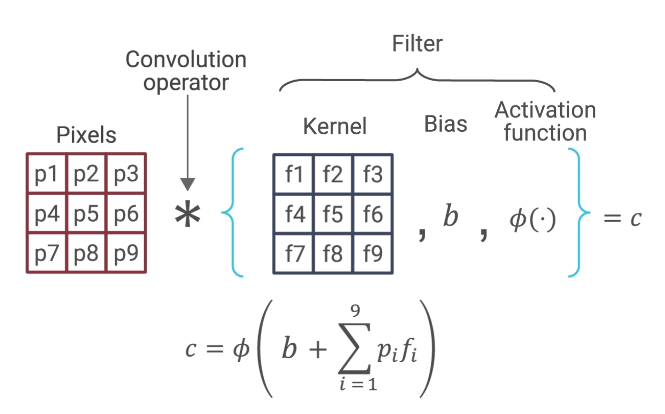

Doing a convolution example for a sample chip and random kernel

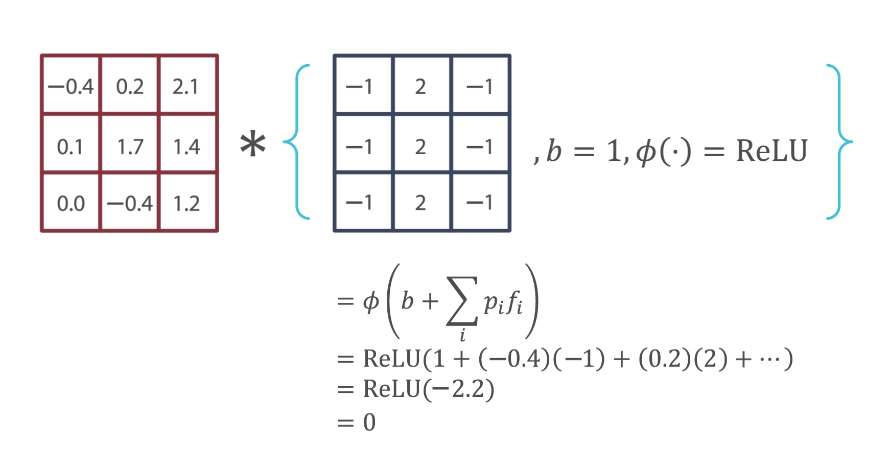

Some filtering options
- since the filter would overhang the image support if applied cenetered on the upper left pixel
    - it is truncated and only applied so that the kernel has full support
    - this crops the size of the image by about half the size of the kernel
    - you can recover the sizing by padding the output with a border of zeros (in keras, set pad = True)
- Additionally, you can stride by a value larger than 1
    - a stride of 2 would recompute the convolution on every other pixel center
    - the feature map is then chopped in half in both dims

Putting together the CNN
- Apply 1 or more filter kernels
- Generates 1 or more feature maps
- Reduce each feature map with a pooling layer
    - An example pooling layer is a max pool
    - Take the neighborhood max for a programmable neighborhood size
- The output of these 2 steps is now N deep, x the 2-d dims per pooled feature map
- Now repeat the above steps, but now need an N-deep kernel set
- After as many steps as you want, you have a highly reduced set
- Vectorize that, and apply softmax

Conceptually, consider the steps prior to the final vectorization and softmax as learning a new set of features
- Then that final feature set is subject to an ordinary multinomial logistic regression

Notice that at no point was it necessary to identify what features to look for
- These were learned by the backpropagation stages in the NN

# 23.2 NN for Vision, Part 1

Problem setup is making a classifier for identifying what number, from 0-9, has been written in a 28x28 pixel image
- A dense layer CNN (vectorize and classify as shown above in the what not to do content) can do pretty well, getting about 97% test accuracy
- Review how the setup would look in keras
    - The code snippet shows 2 different ways, both valid, to build the model
        - using sequential API
        - or using by manually setting each prior output as input to next layer

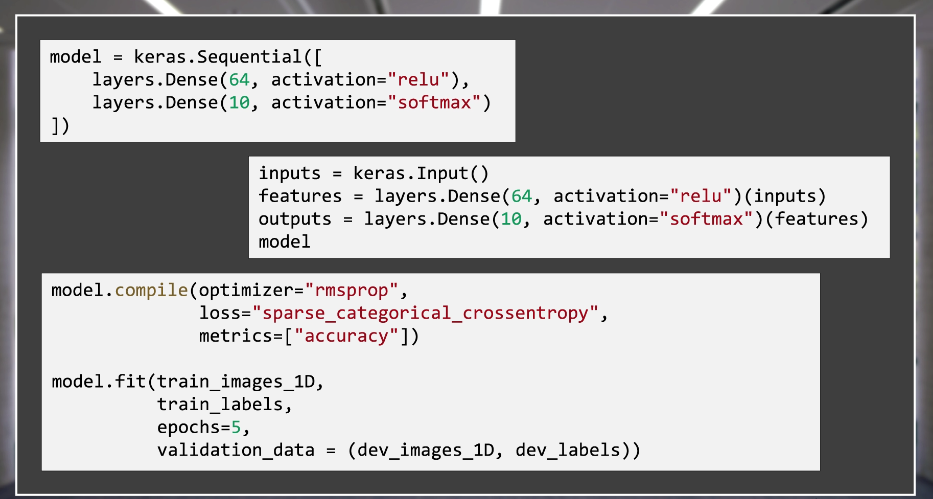

Sample results from running the above model on the MNIST data set
- Not too shabby, but a CNN can be even better

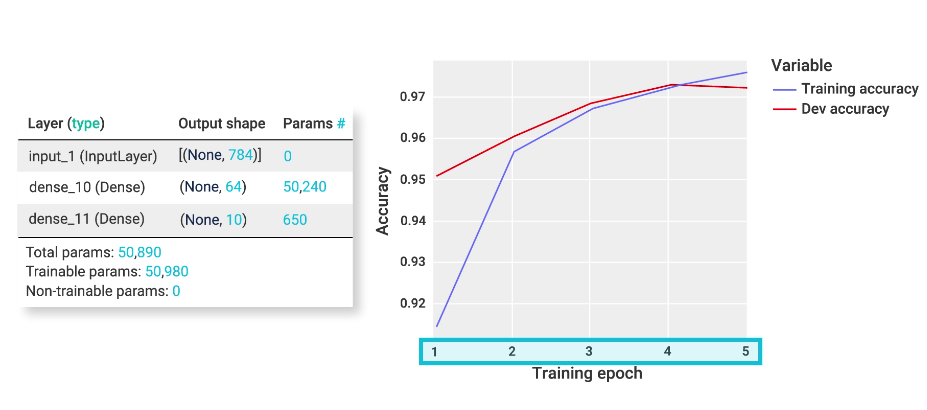

Now look at some code to setup the CNN

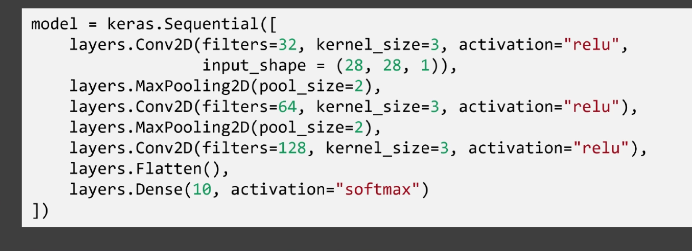

And look at some parameter counts
- Why 320 parameters for layer 1?
    - 32 filters, each of which is 3x3 + 1 or 32 x 10 = 320
- Why is filter 2 18,496 parameters?
    - 64 filters of 10 params each, times the 320 prior parameters, reduced via max pool by 2
        - 64 x 10 x 320 / 2

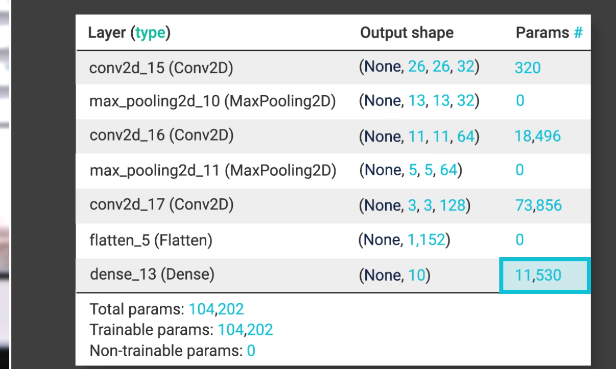

In [26]:
(18496 / 64 - 1) / 12 / 12

2.0

In [28]:
(320 / 32 - 1) / 3 / 3

1.0

Looking at the resulting NN
- use keras.utils, not keras.utils.vis_utils, for current keras versions

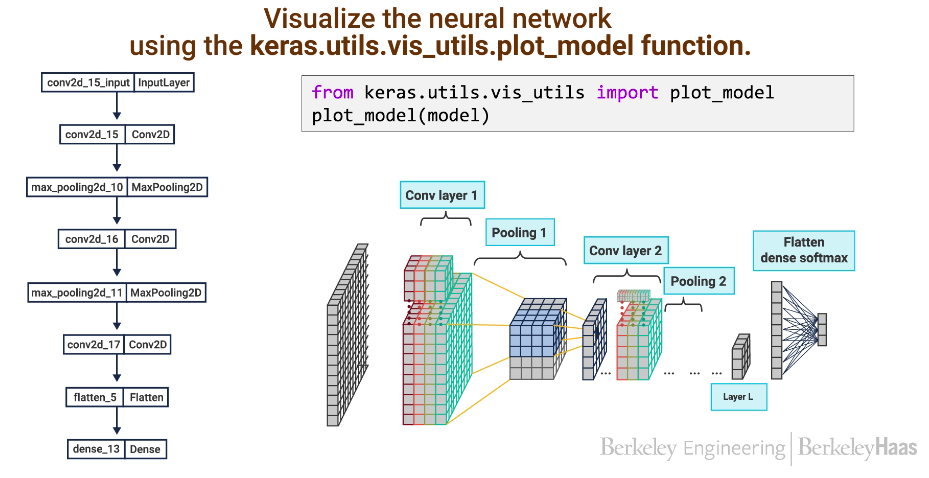

# 23.2 NN for Vision, Part 2

Consider a CNN put together for dogs vs cats
- No consideration for neither dogs nor cats, or dogs and cats

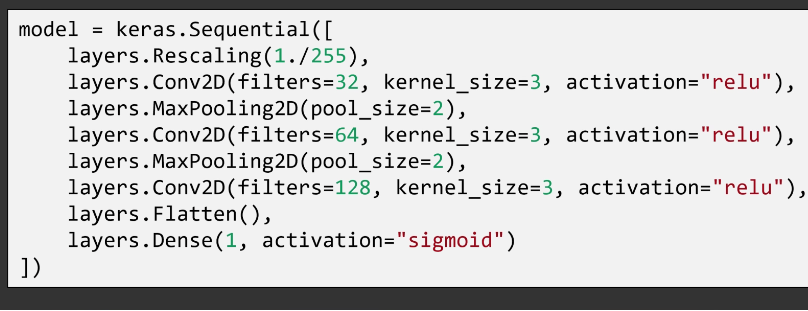

After training this data set, the training accuracy approaches 100%, but the test accuracy stops around 70% - why so bad?
- Even after adding more layers, each one doubling the number of filters from the last, the test accuracy remains quite poor
- What to try next? Here are some things you could try
    - Data augmentation: add distorted, warped, rotated, etc... versions of each image to training set
    - Dropout: randomly remove some connections between neurons
    - There are dozens of such things you can try

One big thing you can do - use a pre-trained network
- Consider a higher performer from 2014 imagenet competition, called vgg16
- it is included in keras/applications

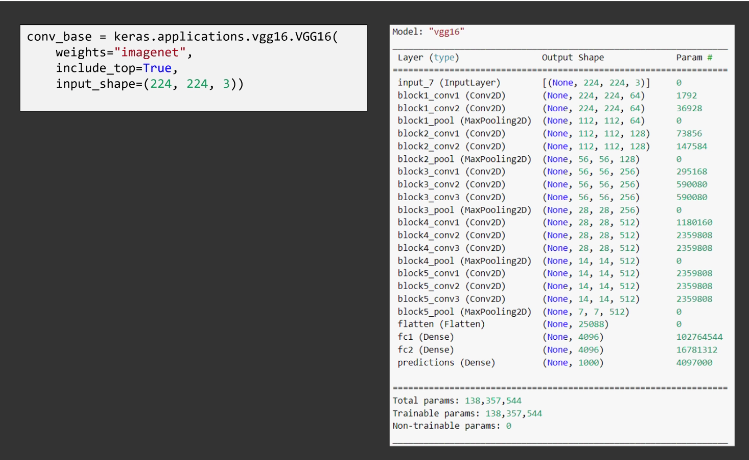

warning: another backwards terminology!!
- the input to an NN is the "bottom"
- while the output is called the "top"

So how did the vgg16 team know how to choose the above, apparently arbitrary network?
- They did not know
- they found it experimentally by trying lots of experiments

Conceptually, its helpful to think of the vgg16 network as 2 basic stages
- stage 1: converts a 224 x 224 x 3 image (3 = RGB) into a 25,088 feature set
- stage 2: converts the feature set to a 10-way probability giving the probability per class membership

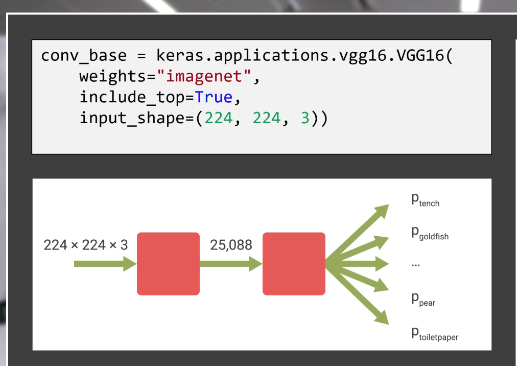

Now somewhat surprisingly, this model can be used for the dog/cat classifier, even though it does not provide labels for dog or cat
- How is this possible?
- Moreover, you can use vgg for other objects not in the data set, such as waterfalls, horses, fires, etc...
- Set parameter `include_top=False` (not True, as shown above)
- Remember, top means end of network
- So include top = false means "dont include the end of the network", which in this case is the flattener and final dense layers
- Now the output is a 7 x 7 x 512
- Now bolt your own flattener and final dense network (1 neuron output) with sigmoid activation
    - To generate your own binary classifier

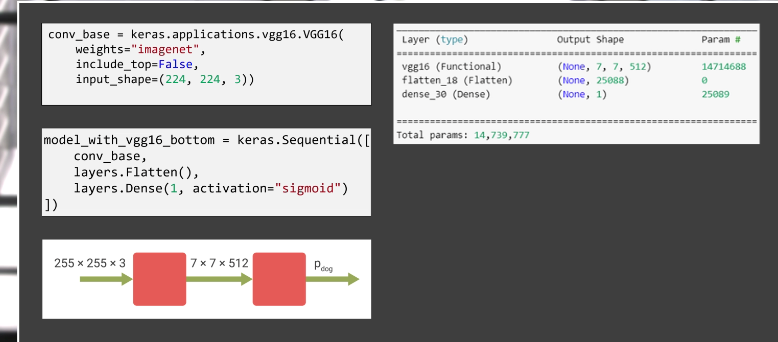

Tweaks before training
- Set trainable to false for the conv base layer, so it is not subject to the gradient descent
    - It becomes a frozen component of the model
- Adopt the weirdo channel swap that vgg16 did (blue was first channel) using preprocess_input step

Final setup shown below
- Notice it also adopts the functional API rather than the sequential API
    - This has no performance impact
    - its just demonstrating the different ways to use the keras library

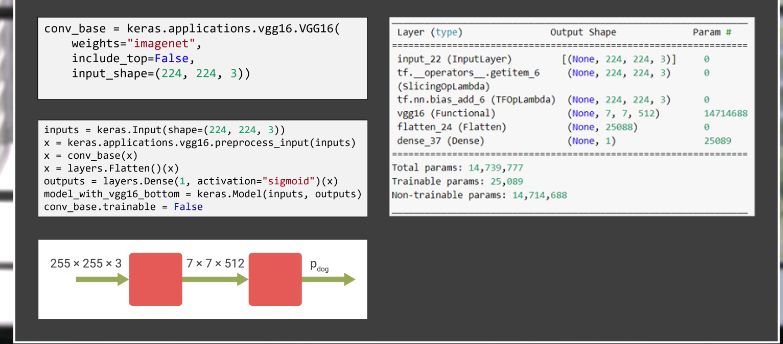

This model now lands around **97%** test accuracy: not bad compared to **70%** before
- In general, great to use pre-trained models if available
- They're going to far deeper, and have far more training in them, than something you can generate yourself

# 23.4 Fine-Tuning Your Model

How to get even better performance?
- You can re-train the last few layers of the vgg model as shown below
- Not sure why the stuff under "first" is shown, since that isn't used in the subsequent code
    - Maybe for comparison purposes
    - So then "first" really means "we started with this"
- Why just the last 3 layers?
    - 3 is not magic, just a choice
    - The bottom layers (i.e. the first or leftmost layers) capture something universal in the data

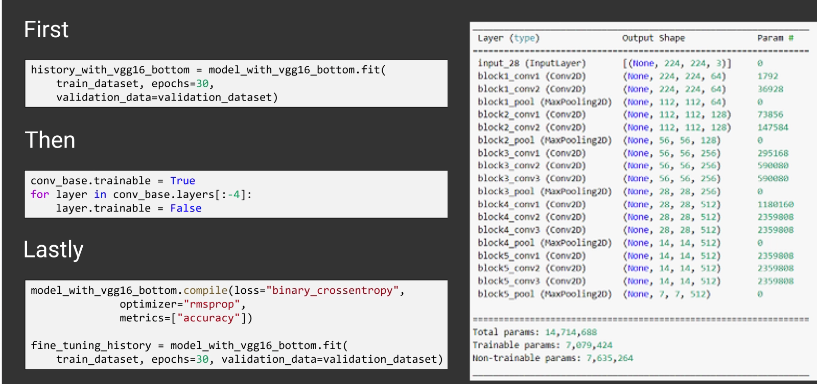

When running this revised model, the test accuracy changed somewhat trivially from 97.blah to 97.blah-blah
- So while underwhelming, the point here was to show the capability, not mind-blowing performance bump

# Mini-Lesson: Tricks of the Trade

Researchers and practitioners acquire knowledge through experience and word-of-mouth, which helps them successfully apply neural networks to complex real-world problems. Unfortunately, the ‘tricks’ they learn, although often theoretically sound, can take years for newcomers to assimilate. As a result, newcomers to the field spend a lot of time wondering why their networks train slowly and perform poorly. This mini-lesson will help you acquire some techniques to assist you in preparing high-performance neural networks. While there are many strategies, this mini-lesson will focus on those relevant to this module. 

**Shuffling the Examples**  
Neural networks learn the fastest from the most random samples. Therefore, selecting a sample that is the most unfamiliar to the system at each iteration is advisable. However, this applies only to stochastic learning (since the batch does not care about the order of the presentation of inputs). Although there is no simple way to determine which inputs are information rich, one straightforward technique that crudely implements this idea is to choose consecutive examples from different classes (since training examples belonging to the same class will most likely contain similar information). 

**Early Stopping**  
Regularization techniques are essential to improve the generalization ability of neural networks. One of the most commonly used strategies is early stopping. This technique can be explained in its simplest form as follows:

Take a validation set that is independent of the training set and monitor the errors on this set during training. In the training set, the error will decrease, whereas, in the validation set, the error will decrease and then increase. The early stopping point occurs when the validation set errors are at their lowest. The network weights are at their most general at this point.

**Neural Networks Classification and Prior Class Probabilities**  
A common problem in multilayer perceptron (MLP) classification is related to the prior probabilities of the individual classes. If the number of training examples that correspond to each class differs significantly, then sometimes, the network may have difficulty learning the rarer classes. When prior class probabilities are unequal, a simple method of alleviating difficulty is to adjust (e.g., equalize) the number of patterns in each class. You can do this either through subsampling (removing patterns from higher frequency classes), or by duplication (of patterns in lower frequency classes). In subsampling, patterns may be removed randomly, or heuristics may be used to remove patterns in regions with low ambiguity. However, subsampling can cause lost information. 

**Applying Divide and Conquer to Large-Scale Pattern Recognition Tasks**  
Traditionally, large-scale problems have always been solved using the divide-and-conquer paradigm, which is a powerful approach. Hence, a hierarchical approach can be used to modularize classification tasks in large-scale application domains, such as speech recognition, where there are thousands of classes and millions of training samples. Divide and conquer proves to be an effective tool for breaking down a complex problem into many smaller tasks. Furthermore, agglomerative clustering can automatically impose a suitable hierarchical structure on a set of classes, even if it contains tens of thousands of classes. In contrast to the relatively small standard benchmarks for learning machines, factors such as training method, model selection, and generalization ability take on a new meaning when dealing with large-scale probability estimation problems.

# 23.5 Interpreting NN for Vision

Each layer implements filters which represent some features
- But how to describe the filters in an interpretable way?
- One way: check out some code from towards data science
- Searches for images that activate a specific filter
    - These are then thought of as exemplar images
    - While multiple different images could cause a filter to pop, the procedure would find just one (the maximizer presumably)
- Think of the examplars as "argmax" of the filter
    - They were found by doing gradient descent with the network parameters fixed but the image changing

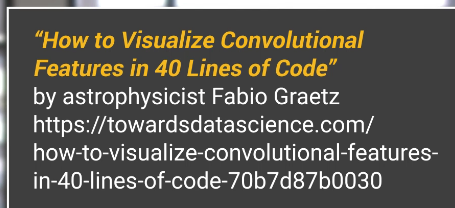

Consider some example images
- one on left causes some filter to pop
- whereas the one on right causes some other filter to pop
- so you could describe these filters as looking for diagonal banding, or 90-degree edges, respectively

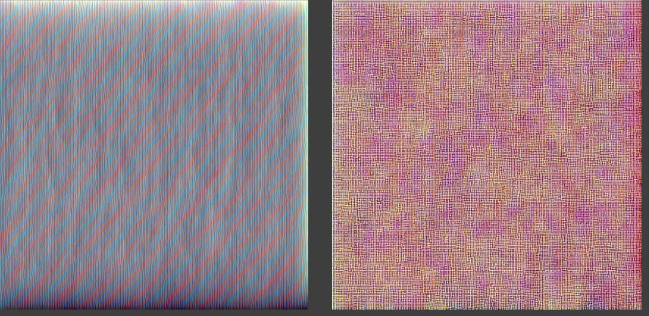

As you go deeper into the network, the images that cause a specific filter to pop become more detailed and recognizable
- The one below looks like some colored chains, and this is from hundreds of layers in

To test a hypothesis that an examplar represents a known "thing", feed an example of such a thing into the layer
- Then if the hypothesis is true, the filter would pop

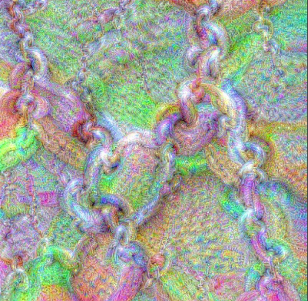

Is the generation of examplar images useful?
- Yes! It gives a way to understand what an NN is doing
Consider the 1-pixel attack concept
- Normally, changing a single pixel in an image would be expected to have no impact on the performance of a model
- But some authors were able to show that by changing just a single pixel, they could drastically alter the outcome of a sample NN
- these 1-pixel modified images can be called optical illusions from the model's perspective

# Overview: NN for Text or Time Series

The use of neural networks for time series forecasting has been widely adopted. Most often, these are feed-forward networks that use a sliding window over the input sequence. Examples include market predictions, meteorological forecasting, and network traffic forecasting. Two of the most popular models used for time series are convolutional neural networks (CNNs) and long short-term memory networks (LSTMs).

**Convolutional Neural Networks (CNNs)**  
CNNs can be used to predict time series from raw input data by learning and automatically extracting features. For example, an observation sequence can be treated as a one-dimensional image from which a CNN model can interpret and extract the salient elements.

**Long Short-Term Memory Networks (LSTMs)**  
LSTMs, which add explicit order handling to the learning of a mapping function from inputs to outputs, are unavailable with MLPs or CNNs. They are neural networks that support sequences of observations as input data.

Neural networks used for this purpose are called recurrent neural networks (RNNs).

# 23.6 NN for Text or Time Series

Developing NN for processing sequential data

NN for sequential data are called recurrent NN (RNN)
- Current point is k (k can be a timepoint or a word in a sentence)
- predicting 1 step forward is k + 1

A naive approach is just to stack up the last N samples in a list and apply to a dense layer
- The issue is that this discards ordering which has to be re-learned
- instead, include the prior model output as another input
- because this prior output depended on the prior N samples, you extend the training set by another 1 sample
- extending this ad infinitum, you get access to all prior history

Recall from regression this concept was called auto-regression (remember ARMA models)
- in the context of NN, self-history is called recurrent
- feed model output back into itself
- the feedback is held in a memory cell
- the depth of the cell is programmable
- the contents of the cell at a point in time is its *state*

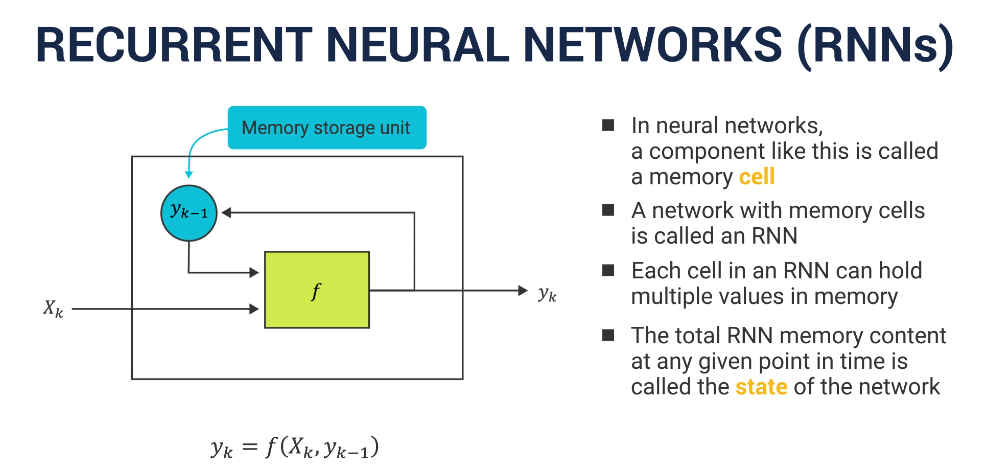

Look at an example simple memory cell in an RNN
- here Xk and Yk can be vectors

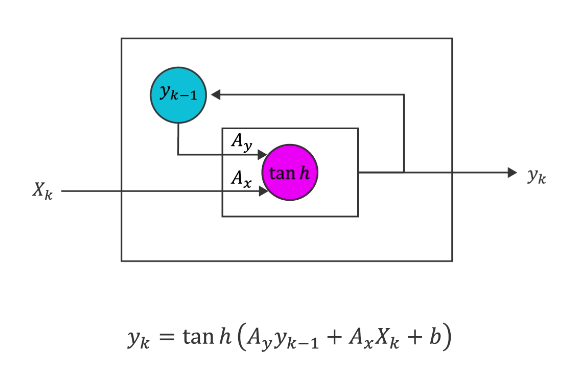

Here is a more complicated memory state called long short-term memory (LSTM)
- the purple state is hidden but combines prior model history from the summation

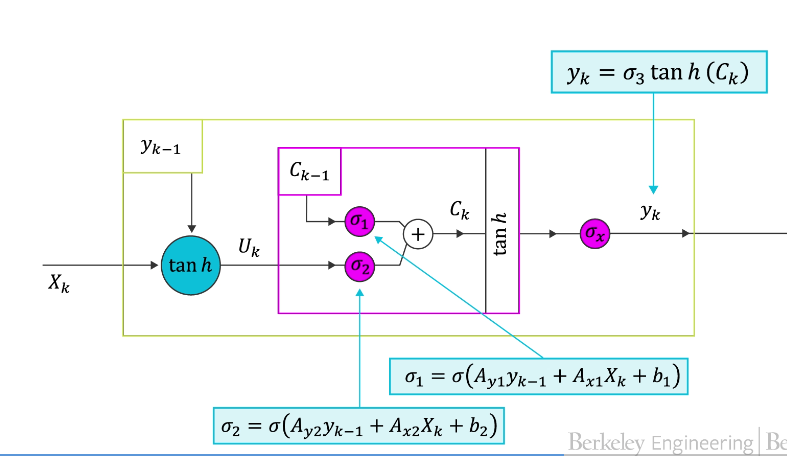

Consider an example of trying to predict traffic flow on the 405 freeway
- The main difference in RNN training and other is how you prep the data
- you have to break it up into windows and partition each window into training and test

Here is some code that will break up the vector data into feature and target data of length 6 hours and 24 hours, respectively
- The idea is to train on 6 hours of data but predict 24 hours into the future
- a seemingly ill-advised problem statement: don't you want the opposite?

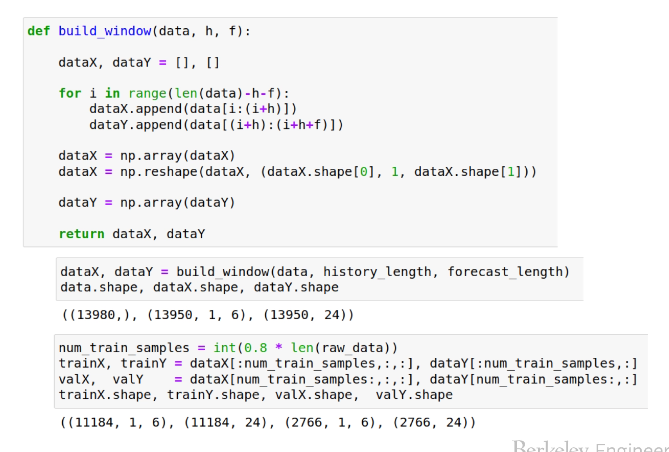

Now try 3 different models: simple flattened layer, an RNN, and an LSTM

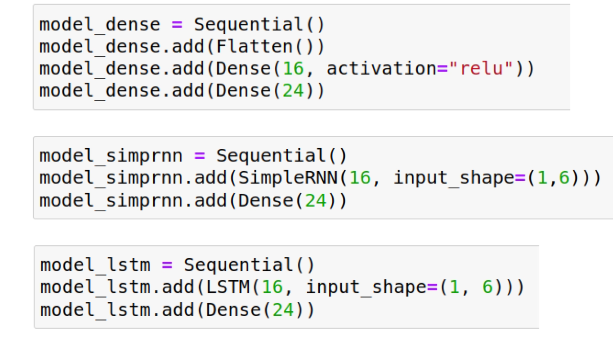

Each model was compiled with loss = mse and run for 500 epochs

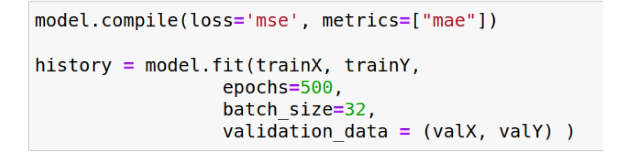

Here is the loss vs. epochs
- The basic model did pretty well but the LSTM was best

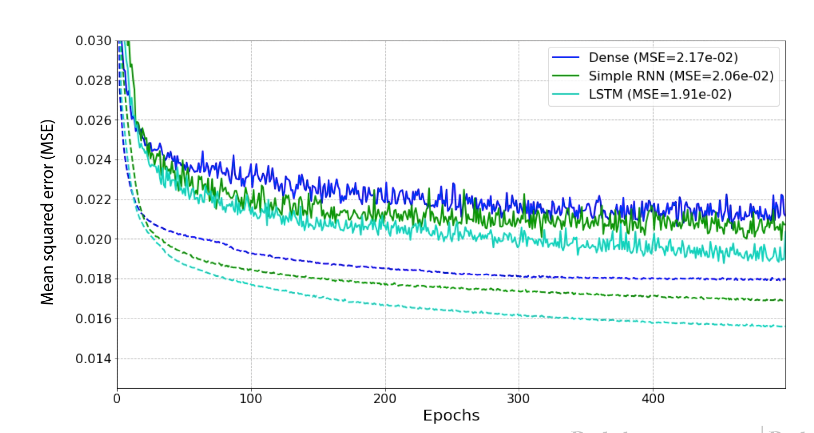

# Overview: NN for Regression

In this section, you will learn about neural networks, in which simple units known as neurons are used as inputs and outputs (inspired by brain neurons). Furthermore, you will discover that neural networks are versatile and are used for both classification and regression. You will also examine how neural networks can be applied to regression problems. Although neural networks are complex and computationally expensive, they are flexible. They can dynamically choose the best type of regression, and you can add hidden layers to improve prediction further.

# 23.7 NN for Regression

Big difference: at the output layer, your **activation is none**
- so the final state becomes a basic linear regression operating on the features generated by all prior layers

Example: sale price of a house
- note new function below, _get_numeric_data
- so you can do dropna on a data set that contains non-numeric data

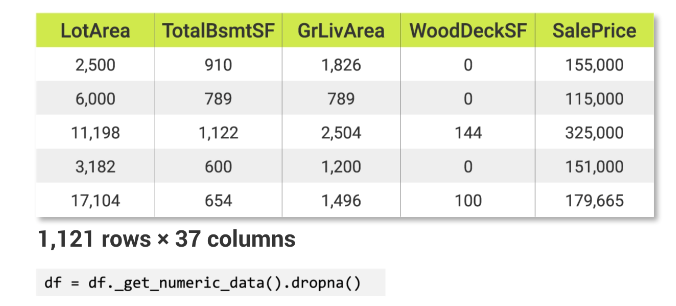
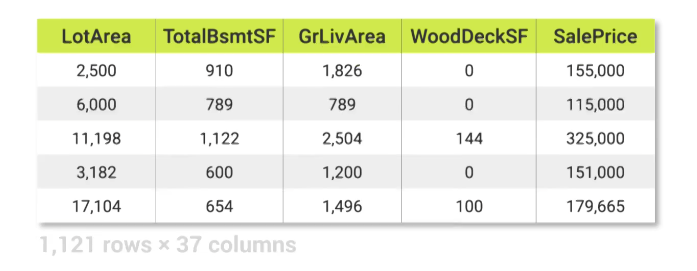

Data setup
- Do a shuffle
- split into training and test
- separate out the target feature (sale price)

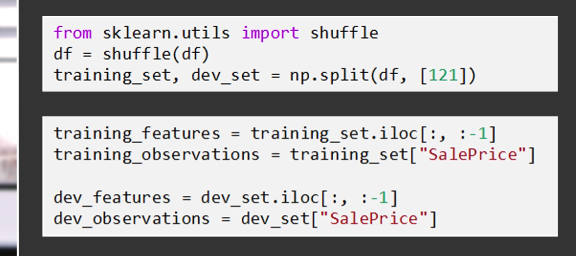

Model setup
- bunch of relu-activated layers
- and a final layer with no activation

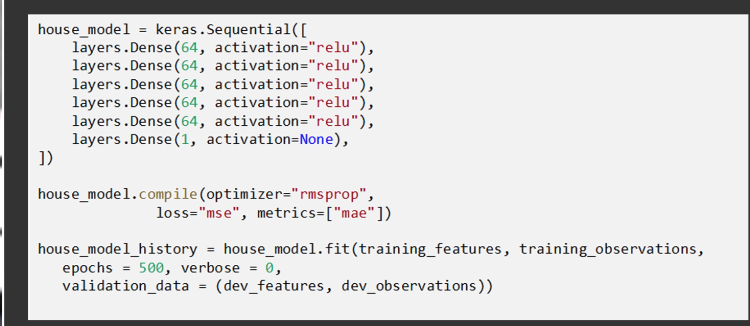

Look at some MAE vs. epoch plots
- the dev error (red line) doesn't blow up going very deep into training
- so can claim the model is probably not overfit
- although its possible if you go further into training, you can see both...
    - a rise in dev MAE (getting worse)
    - and another drop (getting better)
    - recall the double-descent or non-classical regime

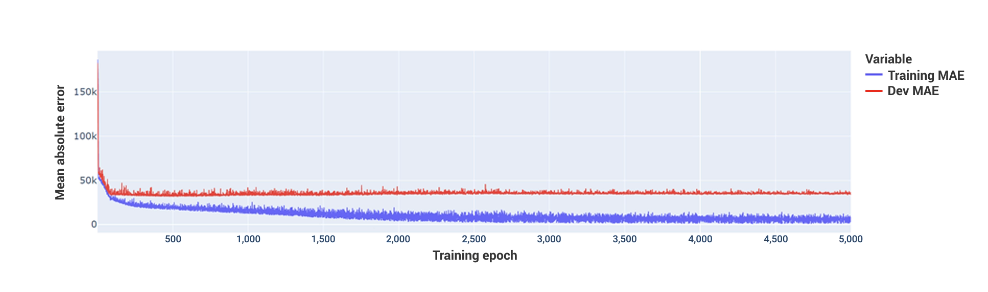